In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

In [2]:
import cv2
import matplotlib 
import numpy as np
import PIL
import torch
import torchvision
%matplotlib inline

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [3]:
# number of subprocesses to use for data loading
num_workers = 2
# how many samples per batch to load
batch_size = 64
# percentage of training set to use as validation
valid_size = 0.2

In [4]:
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
#daata sets paths 
trd_path = '/content/drive/MyDrive/nd101-c2-landmarks-starter-master/landmark_project/landmark_images/train' #training set path 
tsd_path = '/content/drive/MyDrive/nd101-c2-landmarks-starter-master/landmark_project/landmark_images/test'  #test set path 

# we augmenting thew training data using Random rotations, crop, and horizontal flip
train_transforms = transforms.Compose([transforms.RandomRotation(10),
                                       transforms.RandomResizedCrop((224,224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                       ])
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                     ])

train_data = datasets.ImageFolder(trd_path, transform=train_transforms)
test_data = datasets.ImageFolder(tsd_path, transform=test_transforms)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)



In [5]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 
1. For the test data it only resize by stretching the image to fit in 244x244 pixel, and in training the final image will be a 244x244 pixle. However, for data augmentation purpose it will randomly crop the image then resize it to fit a 244x244 pixel. In the model below I tried to mimic the VGG model in a smaller scale, therefor I used the same size for the input.

2. The training and validation dataset are augmented using random rotations and random croping, resizing, and by applying random horizontal flips.  

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

In [6]:
def imshow(img):
    img = img/2 +0.5
    plt.imshow(np.transpose(img, (1,2,0)))

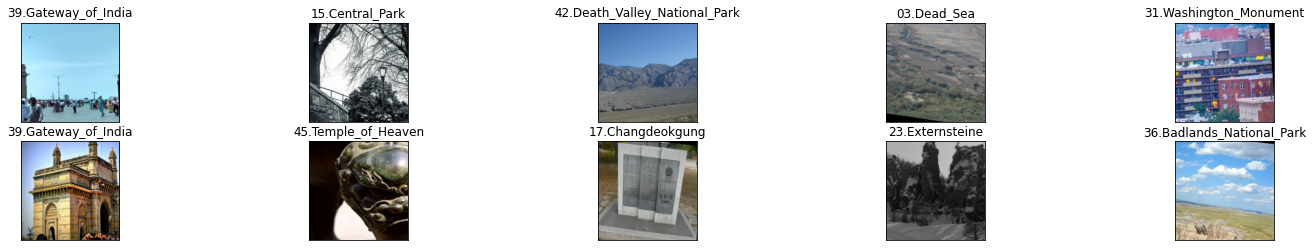

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
classes = train_data.classes
di = iter(loaders_scratch['train'])
images, labels = di.next()
images = images.numpy()

fig = plt.figure(figsize=(25,4))

for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])


In [8]:
len(classes)

50

### Initialize use_cuda variable

In [9]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [10]:
from torch import nn
from torch import optim

In [11]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    optimizer = optim.AdamW(model.parameters(), lr=0.001, amsgrad=True)
    return optimizer

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [12]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 64, 3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(50176, 4000)
        
        self.fc2 = nn.Linear(4000, 1000)
        
        self.fc3 = nn.Linear(1000, 50)
        
        self.dropout = nn.Dropout(0.0)
    
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)

        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  
The convolutional layers were chosen to mimic the architecture of the VGG model. Moreover, the number of fully connected layers are based on the VGG model, however the number of hidden neurans within each hidden layer were the product of experimenting and stopped once achieved a satisfying accuracy. For the dropout layer, I first tried to set the probability to 0 to first check if the model can learn, when I tried to change the probability to 0.25 the model performance seemed to be worse even with more epoch. However, when I tried to remove the dropout layer all together the model was not achieving higher than 2% accuracy. Therefor, I left that layer in.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [13]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

            
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))

            
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss < valid_loss_min:
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
            print('checkpoint')

        
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [14]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
      n = m.in_features
      y = 1/np.sqrt(n)
      m.weight.data.normal_(0, y)
      m.bias.data.fill_(0.01)

    if classname.find('Conv2d') != -1: 
      torch.nn.init.xavier_uniform_(m.weight)
    
    

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, 
                      get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 	Training Loss: 4.203457 	Validation Loss: 3.814670
checkpoint
Epoch: 2 	Training Loss: 3.791290 	Validation Loss: 3.764172
checkpoint
Epoch: 3 	Training Loss: 3.698049 	Validation Loss: 3.705353
checkpoint
Epoch: 4 	Training Loss: 3.644337 	Validation Loss: 3.587751
checkpoint
Epoch: 5 	Training Loss: 3.520496 	Validation Loss: 3.511898
checkpoint
Epoch: 6 	Training Loss: 3.415834 	Validation Loss: 3.477200
checkpoint
Epoch: 7 	Training Loss: 3.370792 	Validation Loss: 3.386618
checkpoint
Epoch: 8 	Training Loss: 3.279104 	Validation Loss: 3.405175
Epoch: 9 	Training Loss: 3.192247 	Validation Loss: 3.256496
checkpoint
Epoch: 10 	Training Loss: 3.076580 	Validation Loss: 3.226563
checkpoint
Epoch: 11 	Training Loss: 2.993186 	Validation Loss: 3.291966
Epoch: 12 	Training Loss: 2.942902 	Validation Loss: 3.133756
checkpoint
Epoch: 13 	Training Loss: 2.845675 	Validation Loss: 3.111701
checkpoint
Epoch: 14 	Training Loss: 2.785329 	Validation Loss: 3.031177
checkpoint
Epoch: 15

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [15]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 30

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.907841 	Validation Loss: 3.889390
checkpoint
Epoch: 2 	Training Loss: 3.857328 	Validation Loss: 3.841745
checkpoint
Epoch: 3 	Training Loss: 3.788362 	Validation Loss: 3.783151
checkpoint
Epoch: 4 	Training Loss: 3.759260 	Validation Loss: 3.762183
checkpoint
Epoch: 5 	Training Loss: 3.699937 	Validation Loss: 3.706136
checkpoint
Epoch: 6 	Training Loss: 3.663654 	Validation Loss: 3.639595
checkpoint
Epoch: 7 	Training Loss: 3.584891 	Validation Loss: 3.633810
checkpoint
Epoch: 8 	Training Loss: 3.577163 	Validation Loss: 3.588651
checkpoint
Epoch: 9 	Training Loss: 3.524333 	Validation Loss: 3.620108
Epoch: 10 	Training Loss: 3.480415 	Validation Loss: 3.519628
checkpoint
Epoch: 11 	Training Loss: 3.407240 	Validation Loss: 3.448410
checkpoint
Epoch: 12 	Training Loss: 3.344616 	Validation Loss: 3.457221
Epoch: 13 	Training Loss: 3.287766 	Validation Loss: 3.336871
checkpoint
Epoch: 14 	Training Loss: 3.206699 	Validation Loss: 3.309931
checkpoint
Epoch: 15

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [16]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.427354


Test Accuracy: 36% (459/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [17]:
# number of subprocesses to use for data loading
num_workers = 2
# how many samples per batch to load
batch_size = 64
# percentage of training set to use as validation
valid_size = 0.2


from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
#daata sets paths 
trd_path = '/content/drive/MyDrive/nd101-c2-landmarks-starter-master/landmark_project/landmark_images/train' #training set path 
tsd_path = '/content/drive/MyDrive/nd101-c2-landmarks-starter-master/landmark_project/landmark_images/test'  #test set path 

# we augmenting thew training data using Random rotations, crop, and horizontal flip
train_transforms = transforms.Compose([transforms.RandomRotation(10),
                                       transforms.RandomResizedCrop((224,224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                       std=[0.229, 0.224, 0.225])
                                       ])
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])
                                     ])

train_data = datasets.ImageFolder(trd_path, transform=train_transforms)
test_data = datasets.ImageFolder(tsd_path, transform=test_transforms)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)


In [18]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [19]:
## TODO: select loss function
from torch import nn
from torch import optim
criterion_transfer = nn.CrossEntropyLoss()

def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
  optimizer = optim.AdamW(model.classifier.parameters(), lr=0.001, amsgrad=True)
  return optimizer   

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [20]:
## TODO: Specify model architecture
import torchvision.models as models
model_transfer = models.vgg16(pretrained=True)
model_transfer.classifier[6] = nn.Linear(4096, 50)

for parm in model_transfer.features: 
  parm.requires_grad = False
#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

In [21]:
print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  
The VGG model proved to be a capable model for similar tasks based on work done [here](https://github.com/vfaramond/landmarks-recognition/blob/master/notebooks/4%20-%20Fine-tuning.ipynb) therefore I've picked it for this task. Moreover, I changed the fainal layer in the classifier to map into our 50 output classes. Finally, i froze all the features layers and only trained the classifier.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [22]:
del model_scratch

In [23]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'

train(15, loaders_transfer, model_transfer,get_optimizer_transfer(model_transfer), criterion_transfer, use_cuda,'model_transfer.pt')

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.623771 	Validation Loss: 1.948328
checkpoint
Epoch: 2 	Training Loss: 1.944765 	Validation Loss: 1.706268
checkpoint
Epoch: 3 	Training Loss: 1.766773 	Validation Loss: 1.532480
checkpoint
Epoch: 4 	Training Loss: 1.767154 	Validation Loss: 1.550969
Epoch: 5 	Training Loss: 1.677136 	Validation Loss: 1.470632
checkpoint
Epoch: 6 	Training Loss: 1.642721 	Validation Loss: 1.577569
Epoch: 7 	Training Loss: 1.701167 	Validation Loss: 1.426700
checkpoint
Epoch: 8 	Training Loss: 1.713396 	Validation Loss: 1.447763
Epoch: 9 	Training Loss: 1.639575 	Validation Loss: 1.485914
Epoch: 10 	Training Loss: 1.614805 	Validation Loss: 1.576271
Epoch: 11 	Training Loss: 1.590308 	Validation Loss: 1.399314
checkpoint
Epoch: 12 	Training Loss: 1.576738 	Validation Loss: 1.391299
checkpoint
Epoch: 13 	Training Loss: 1.669040 	Validation Loss: 1.447396
Epoch: 14 	Training Loss: 1.540715 	Validation Loss: 1.429103
Epoch: 15 	Training Loss: 1.511479 	Validation Loss: 1.448633


<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [24]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.137159


Test Accuracy: 70% (885/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [25]:
import cv2
from PIL import Image
import torchvision.transforms.functional as TF

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    if k > 50:
      k = 50
    transforms_ = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])
                                     ])
    image = Image.open(img_path)
    image = transforms_(image).float()
    image = image.unsqueeze(0)  
    image = image.cuda() 
    
    output = model_transfer(image)

    
    _, preds_tensor = torch.topk(output, k, sorted=True)
    l = []
    preds_tensor = preds_tensor.cpu()
    for pred in preds_tensor[0]: 
      l.append(test_data.classes[pred][3:])
    return l



# test on a sample image
predict_landmarks('/content/drive/MyDrive/nd101-c2-landmarks-starter-master/landmark_project/images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Golden_Gate_Bridge',
 'Forth_Bridge',
 'Brooklyn_Bridge',
 'Sydney_Harbour_Bridge',
 'Dead_Sea']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

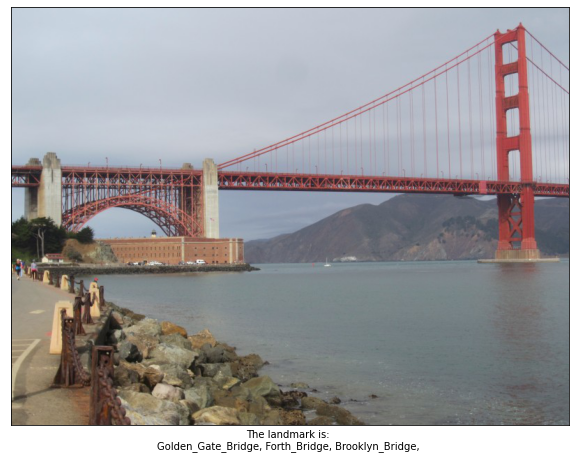

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    ## TODO: display image and display landmark predictions
    img = mpimg.imread(img_path)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
    #"The landmark is: \n %s" % (index, value) for index, value in enumerate(predicted_landmarks)
    st = "The landmark is: \n"
    for i in predicted_landmarks:
      st =st+str(i)+", "
    ax.set_xlabel(st)
    plt.imshow(img)

    
    

# test on a sample image
suggest_locations('/content/drive/MyDrive/nd101-c2-landmarks-starter-master/landmark_project/images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

we can improve the algorithm by: 
1. test other pretrained models to see if it can outperform the VGG model used
2. train the model using more data and more epochs 
3. develop a custom classifier with more complex layers. 

__Answer:__ (Three possible points for improvement)

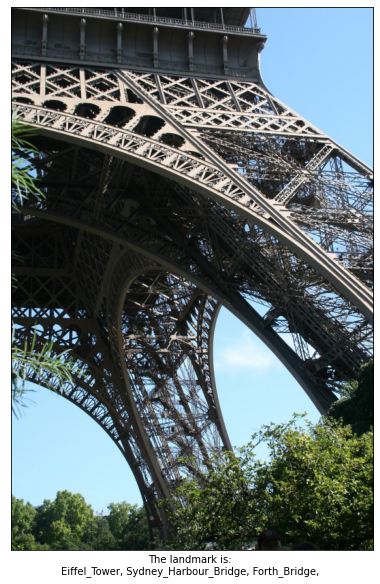

In [30]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
suggest_locations('/content/drive/MyDrive/nd101-c2-landmarks-starter-master/landmark_project/images/test/16.Eiffel_Tower/3828627c8730f160.jpg')


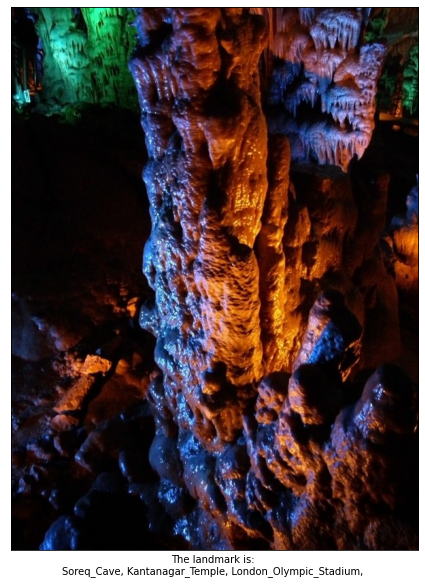

In [32]:
suggest_locations('/content/drive/MyDrive/nd101-c2-landmarks-starter-master/landmark_project/images/test/24.Soreq_Cave/18dbbad48a83a742.jpg')


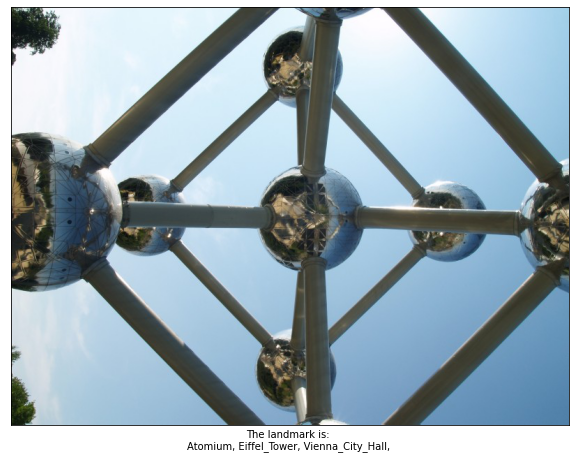

In [33]:
suggest_locations('/content/drive/MyDrive/nd101-c2-landmarks-starter-master/landmark_project/images/test/37.Atomium/5ecb74282baee5aa.jpg')

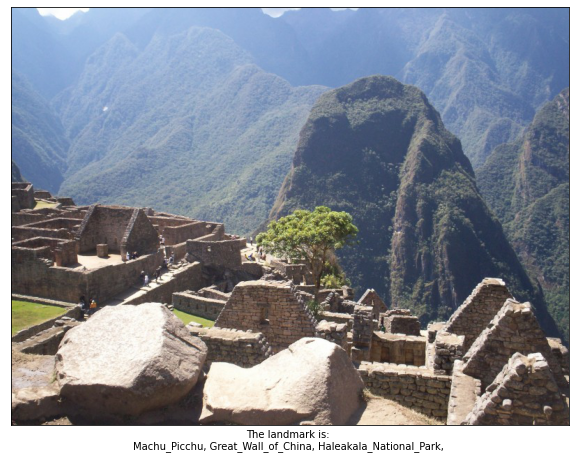

In [34]:
suggest_locations('/content/drive/MyDrive/nd101-c2-landmarks-starter-master/landmark_project/images/test/41.Machu_Picchu/4336abf3179202f2.jpg')